# Init
Import dependencies

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Import FSK dataset
This dataset contains 4 types of FSK modulation
"0", "00", "1" and "11".


In [4]:
data_dir = pathlib.Path('data/db')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'db.zip',
      origin="https://github.com/Irreq/tism/raw/main/db.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

# Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.
train_files = filenames[:600]
val_files = filenames[600: 600 + 200]
test_files = filenames[-200:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

5677056/5669375 [==============================] - 0s 0us/step
Commands: ['0' '1' '11' '00']
Number of total examples: 1000
Number of examples per label: 234
Example file tensor: tf.Tensor(b'data/db/11/45.wav', shape=(), dtype=string)
Training set size 600
Validation set size 200
Test set size 200


# Reading audio files and their labels
The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use tf.audio.decode_wav, which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. Note that tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].


In [15]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([4410] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

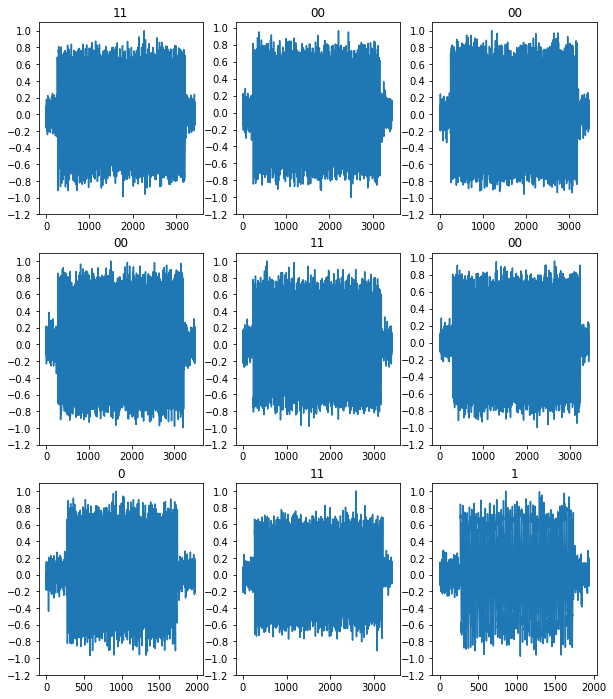

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: 11
Waveform shape: (3436,)
Spectrogram shape: (33, 129)
Audio playback


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


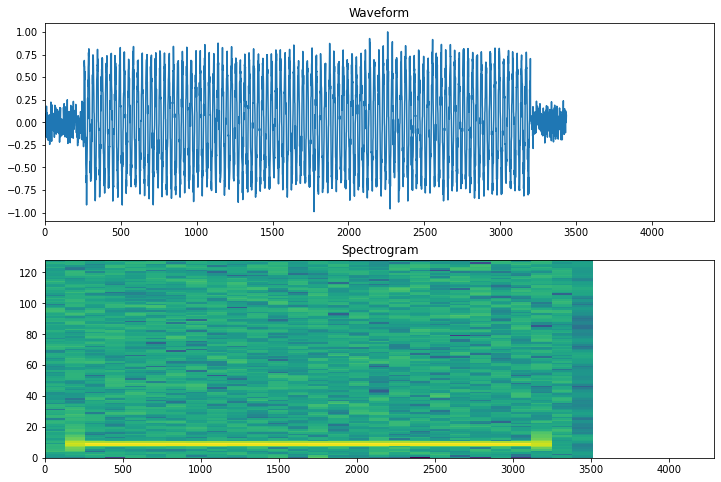

In [14]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(4410, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 4410])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


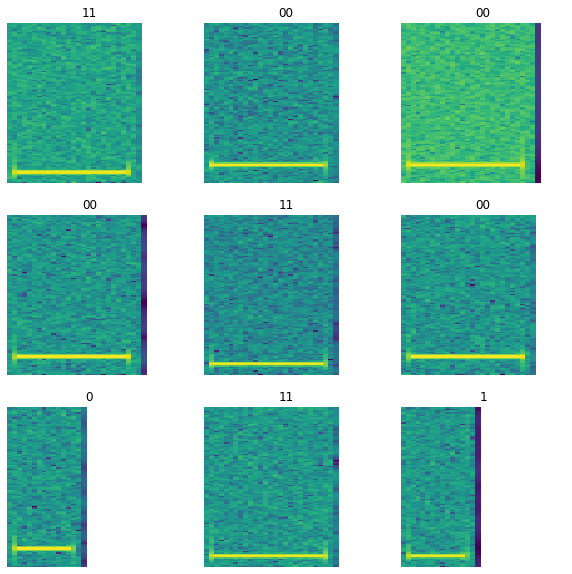

In [16]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

# Model

In [30]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 4
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (33, 129, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_3 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)         

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 5
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
150/150 [==============================] - 5s 30ms/step - loss: 0.4275 - accuracy: 0.8147 - val_loss: 2.5755e-06 - val_accuracy: 1.0000
Epoch 2/5
150/150 [==============================] - 4s 24ms/step - loss: 0.0036 - accuracy: 0.9984 - val_loss: 3.7866e-06 - val_accuracy: 1.0000
Epoch 3/5
150/150 [==============================] - 3s 22ms/step - loss: 2.4852e-04 - accuracy: 1.0000 - val_loss: 1.6034e-07 - val_accuracy: 1.0000
Epoch 4/5
150/150 [==============================] - 3s 23ms/step - loss: 5.0937e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
150/150 [==============================] - 3s 23ms/step - loss: 0.0339 - accuracy: 0.9853 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


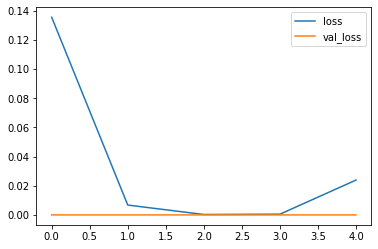

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


# Confusion Matrix

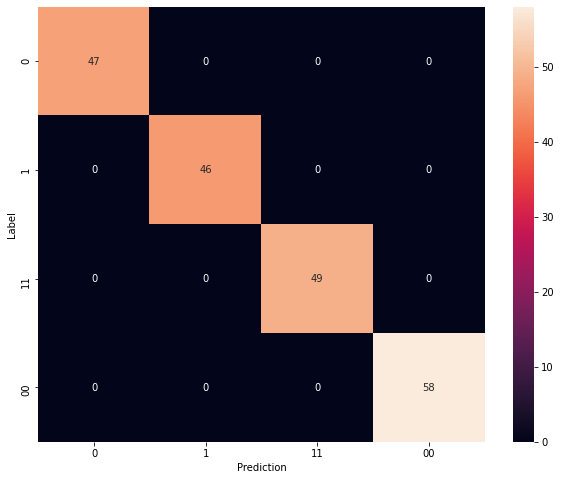

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [78]:
def predict(spectrogram, commands=commands):
  prediction = model(spectrogram)
  all = tf.nn.softmax(prediction[0])
  values = np.array(all).tolist()
  tag = values.index(max(values))

  return commands[tag], all

def test_print():
  sample_file = data_dir/'0/110.wav'

  sample_ds = preprocess_dataset([str(sample_file)])

  for spectrogram, label in sample_ds.batch(1):

    predict, result = predict(spectrogram)

    plt.bar(commands, result)
    plt.title(f'Overall predictions for: "{commands[label[0]]}"')
    plt.show()

    print(f"prediction: {predict}")
    print(f"ground truth: {commands[label[0]]}")
    print(f"conclusion: {predict==commands[label[0]]}")

sample_file = data_dir/'00/10.wav'

sample_ds = preprocess_dataset([str(sample_file)])


for spectrogram, label in sample_ds.batch(1):
  print(spectrogram.shape)
  print(spectrogram)

(1, 33, 129, 1)
tf.Tensor(
[[[[0.7685828 ]
   [0.52795243]
   [0.6936734 ]
   ...
   [1.4816953 ]
   [2.0996008 ]
   [2.027537  ]]

  [[0.46356815]
   [0.58439535]
   [0.78924453]
   ...
   [0.9521431 ]
   [0.6491175 ]
   [0.9297249 ]]

  [[0.2501003 ]
   [0.7553557 ]
   [1.318208  ]
   ...
   [1.4420065 ]
   [1.6876317 ]
   [1.2797468 ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]], shape=(1, 33, 129, 1), dtype=float32)


In [79]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)